## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conc)
- [Suggestions](#sugg)
- [References](#ref)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Read dataset
df = pd.read_csv('ab_data.csv')
# Look at the top few rows 
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# Print number of rows in the dataset
row_num = df.shape[0]
print("Total no. of rows: {}".format(row_num))

Total no. of rows: 294478


c. The number of unique users in the dataset.

In [4]:
# Number of unique users in the dataset
user_total = df.user_id.nunique()
print("Total no. of unique users: {}".format(user_total))

Total no. of unique users: 290584


d. The proportion of users converted.

In [5]:
# The proportion of users converted
print("The proportion of users converted: {}".format(df.converted.mean()))

The proportion of users converted: 0.11965919355605512


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
#Count the number of lines where new_page and control are aligned, and add them with old page and treatment
dont_line = df.query('landing_page == "new_page" and group == "control"').count()[0] + df.query('landing_page == "old_page" and group == "treatment"').count()[0]
print("The number of times the new_page and treatment don't line up: {}".format(dont_line))

The number of times the new_page and treatment don't line up: 3893


f. Do any of the rows have missing values?

In [7]:
#Find the missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#### Ans 1 (f): There are no missing value.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#Filter on lines where new page and control are aligned
new_control = df[(df.landing_page == "new_page") & (df.group == "control")]

#Filter on lines where old page and treatment are aligned
old_treatment = df[(df.landing_page == "old_page") & (df.group == "treatment")]

#Concatenate the inaccurate lines 
inaccurate = pd.concat([new_control, old_treatment])

#Assign the index for these lines
inaccurate_index = inaccurate.index

#Drop the lines with the indexes assigned above
df2 = df.drop(inaccurate_index)

In [9]:
# Validate the data without inaccurate lines 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
#Check the new dataframe df2
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
#Number of unique users
df2_user_total = df2.user_id.nunique()
print("Total no. of unique users in df2: {}".format(df2_user_total))

Total no. of unique users in df2: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#Find the duplicate user_id in df2
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### Therefore user_id: 773192 is duplicated in df2

c. What is the row information for the repeat **user_id**? 

In [13]:
#Row information for the repeat user_id=773192
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#Remove one of the duplicate rows
df2.drop(labels = 1899, axis=0, inplace=True)

In [15]:
#Validate removal of a row 
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### Only one row remain of user_id 773192

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
#Given that "1"is considered as "True"
df2_converted = df2['converted'].mean()
print("The probability of an individual converting regardless of the page they receive: {}".format(df2_converted))

The probability of an individual converting regardless of the page they receive: 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#Probability of the users converted in control group
df2_converted_control=df2[df2['group'] == "control"]['converted'].mean()
print("The probability they converted in control group: {}".format(df2_converted_control))

The probability they converted in control group: 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#Probability of the users converted in treatment group
df2_converted_treatment=df2[df2['group'] == "treatment"]['converted'].mean()
print("The probability they converted in treatment group: {}".format(df2_converted_treatment))

The probability they converted in treatment group: 0.11880806551510564


d. What is the probability that an individual received the new page?

In [19]:
#Probability of the users landing on new page
df2_landing_new=(df2.landing_page == "new_page").mean()
print("The probability they received the new page: {}".format(df2_landing_new))

The probability they received the new page: 0.5000619442226688


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**According to the proportions results, there are small variation between users converted from treatment group and control group, therefore there is insufficient evidence to say that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypothesis**

$H_{0}$ : $p_{old}$ >=  $p_{new}$

$H_{1}$ : $p_{old}$ <  $p_{new}$

**OR**

$H_{0}$ : $p_{old}$ - $p_{new}$ >= 0

$H_{1}$ : $p_{old}$ - $p_{new}$ <0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
#Assume p_new and p_old are equal, then find the proportion of converted rate for p_new
p_new = df2['converted'].mean()
print("The convert rate for p_new under the null: {}".format(p_new))

The convert rate for p_new under the null: 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
#Assume p_new and p_old are equal, then find the proportion of converted rate for p_old
p_old = df2['converted'].mean()
print("The convert rate for p_old under the null: {}".format(p_old))

The convert rate for p_old under the null: 0.11959708724499628


c. What is $n_{new}$?

In [22]:
#Number of users landing on new page
n_new = len(df2.query("group == 'treatment'"))
print("The no. of users landing on new page are: {}".format(n_new))

The no. of users landing on new page are: 145310


d. What is $n_{old}$?

In [23]:
#Number of users landing on old page
n_old = len(df2.query("group == 'control'"))
print("The no. of users landing on old page are: {}".format(n_old))

The no. of users landing on old page are: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#Draw samples from a binomial distribution of new_page_converted
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
#Draw samples from a binomial distribution of old_page_converted
old_page_converted = np.random.binomial(1, p_old,n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
#Since no. of rows of new page (145310 rows) are higher than old page (145274 rows), so we truncate the new page up to the old page (145274 rows)
new_page_converted_2 = new_page_converted[:145274]
#Compute the difference between new and old pages
p_diff = new_page_converted_2.mean() - old_page_converted.mean()
print("The difference between new and old pages are: {}".format(p_diff))

The difference between new and old pages are: -0.0006057518895328795


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
#Store all 10,000 values in a numpy array p_diffs.
p_diffs = []
#Simulate 10,000  p_new and p_old
for _ in range(10000):
    new_page_converted_3 = np.random.binomial(1, p_new, n_new)
    old_page_converted_3 = np.random.binomial(1, p_old, n_old)
    new_page_p = new_page_converted_3.mean()
    old_page_p = old_page_converted_3.mean()
    p_diffs.append(new_page_p - old_page_p)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

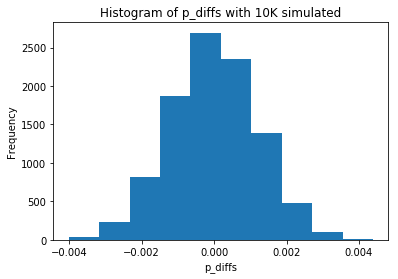

In [28]:
#Plot a histogram of the p_diffs
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Histogram of p_diffs with 10K simulated');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
#Actual difference observed in ab_data.csv
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
act_diff
print("The proportion of the p_diffs are: {}".format(act_diff))

The proportion of the p_diffs are: -0.0014795997940775518


In [30]:
#Convert p_diffs to numpy array and calculate the p-value
p_diffs = np.array(p_diffs)
#Proportion of p_diffs are greater than the actual difference observed in ab_data.csv
proportion = (p_diffs > act_diff).mean()
print("The proportion of the p_diffs are: {}".format(proportion))

The proportion of the p_diffs are: 0.8899


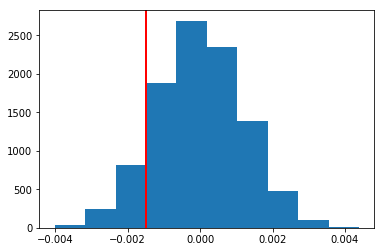

In [31]:
plt.hist(p_diffs);
plt.axvline(act_diff,c='r',linewidth = 2);

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

* **Actual difference is the difference between converted rates of new page and old page, which based on dataset.**

* **p-diffs are the simuated difference between converted rates of new page and old page which based on 10000 simulated samples.**

* **The proportion of 0.8963 is p-value, which determines the probability of our observed statistic if the null hypothesis is true.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm
#Number of conversions for each page
convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
#Number of individuals who received each page
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))
print("Number of conversions for each old page are: {}".format(convert_old))
print("Number of conversions for each new page are: {}".format(convert_new))
print("Number of individuals who received each old page are: {}".format(n_old))
print("Number of individuals who received each new page are: {}".format(n_new))

Number of conversions for each old page are: 17489
Number of conversions for each new page are: 17264
Number of individuals who received each old page are: 145274
Number of individuals who received each new page are: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
#compute test statistic and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print("z score is: {}".format(z_score))
print("p value is: {}".format(p_value))

z score is: 1.3109241984234394
p value is: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [34]:
from scipy.stats import norm
# Determine the significant of z-score
print(norm.cdf(z_score))
# Assume 95% confidence level,
print(norm.ppf(1-(0.05)))

0.905058312759
1.64485362695


* **We find that the z-score of 1.3109241984234394 is less than the critical value of 1.64485362695. So, we accept the null hypothesis.**
* **In regard to the conversion rates of old and new pages, we found that old pages are slightly better than new pages.**
* **These values agree with the findings in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
#Create intercept 
df2['intercept']=1
#Create dummy variables
ab_page = ['treatment', 'control']
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']
#check dataset
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
logit = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:               8.077e-06
Time:                        14:23:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

* **From Logit Regression Results, p-value associated with ab_page column is 0.19 which is lower than the p-value (0.905) calculated by z test.**

* **Because in part 3, we are performing two-tailed test. It means when using a two-tailed test, regardless of the direction of the relationship we hypothesize, we are testing for the possibility of the relationship in both directions.**

* **While in part 2, we are using a one-tailed test. It means we are testing for the possibility of the relationship in one direction and completely disregarding the possibility of a relationship in the other direction. A one-tailed test will test either if the mean is significantly greater than x or if the mean is significantly less than x, but not both.**

* **Like this logit regression, there are only two possible outcomes. (1) new page is equal to old page or (2) new page is different to old page.**
$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} != 0$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

* **Becasuse in this case, the relationship is not truely linearity between our response (ap_page) and predictor variables (converted). So our predictions will not be very accurate. **

* **Multiple regression allows us to control for those “other” factors. The more variables (x1, x2,...xn), y will be able more to explain and got better predictions.**

* **However, there are disadvantages to adding additional terms into our regression model.One of the most common adverse impact is Collinearity (Multi-collinearity). It is occurred when we have predictor variables that are correlated with one another. Finally, it can lead to coefficients being flipped from the direction we expect from simple linear regression.**

* **Therefore, in order to identify whether multicollinearity has existed in our model. We can perform bivariate plots or with variance inflation factors (or VIFs). **

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
#Read countries.csv dataset 
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
#Check the dataset
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [39]:
#Check how many counties in dataset 
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
#Create the necessary dummy variables
df_new[['CA', 'US','UK']] = pd.get_dummies(df_new['country'])[['CA','US','UK']]
#Check columns
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,UK
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
### Fit Your Linear Model And Obtain the Results
df['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US','ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.424150
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 10 Dec 2018   Pseudo R-squ.:                 -0.1585
Time:                        14:23:32   Log-Likelihood:            -1.2325e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -1.6274      0.026    -61.490      0.000      -1.679      -1.576
US            -1.5886      0.007   -212.017      0.000      -1.603      -1.574
ab_page       -1.0042      0.009   -109.613      0.000      -1.022      -0.986
==============================================================================
"""

In [42]:
np.exp(results.params)

CA         0.196444
US         0.204210
ab_page    0.366351
dtype: float64

In [43]:
1/_

0.00010001000100010001

In [44]:
df.groupby('group').mean()['converted']

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

<a id='conc'></a>
## Conclusions

* **We found that interaction between page and country are not significant effects on conversion.**

* **Therefore, we are accepted the null hypothesis which means a new page is equal to old page.**

<a id='sugg'></a>
## Suggestions
* **We could add more attributes in the dataset in order to verify the effectiveness of new page.**
* **Based on existing outcomes, we can amend the design of new page and re-run the experiemnt.**
* **And better to run the experiment longer to make their decision.**

<a id='ref'></a>
## References
http://blog.analytics-toolkit.com/2017/statistical-significance-ab-testing-complete-guide/